In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.metrics import r2_score
import matplotlib
from analyse_embeddings import SUBJ_NAME

sns.set_theme(style="whitegrid")

sns.color_palette("Set2")

scales_df = pd.read_pickle("../data/scaling.pkl").set_index(["sph", "add"])
scales_df['subj'] = scales_df['subj'].map(SUBJ_NAME)
print(f"{len(scales_df.subj.unique())} observers")

13 observers


In [159]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sb
# actively reload module (during working on analyse_embeddings.py)
import importlib
import matplotlib.image as mpimg
import mat73
font = {'family' : 'Helvetica',
        #'sans-serif': ['Helvetica'],
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
matplotlib.rc('axes.spines',right=False)
matplotlib.rc('axes.spines',top=False)
matplotlib.rc('axes',edgecolor='black')
matplotlib.rc('xtick',color='black',bottom=True)
matplotlib.rc('ytick',color='black',left=True)


### COLOR definitions ###
#colors of undistorted and distorted mesh
color_undist = np.array([0,105,170])/255
color_dist = np.array([200,80,60])/255

# for yaw, pitch and roll
colors_ypr = [ np.array([210,150,0])/255,
               np.array([80,170,200])/255,
               np.array([175,110,150])/255]

# for undistorted, add 1 add 3
colors_add1 =  np.array([50,110,30])/255
colors_add3 =  np.array([200,80,60])/255

colors_add1 = sb.blend_palette(['#214017','#326e1e','#4ad41c'],13)
colors_add3 = sb.blend_palette(['#994738','#ee5c43','#ed8e7d'],13)

color_dynobs = np.array([130,185,160])/255
color_statobs = np.array([215,180,105])/255
 #sb.color_palette("Oranges")

In [5]:
lens_param_df = scales_df.reset_index()
lens_param_df

,sph,add,subj,scaling
0,-5.0,1.0,1,-0.219970
1,-5.0,3.0,1,0.110867
2,-2.5,1.0,1,-0.219969
3,-2.5,3.0,1,0.195304
4,0.0,0.0,1,-0.255782
...,...,...,...,...
138,0.0,3.0,13,0.304306
139,2.5,1.0,13,0.504559
140,2.5,3.0,13,0.618504
141,5.0,1.0,13,0.846172


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import curve_fit


class ExponentialFit(BaseEstimator, RegressorMixin):
    @staticmethod
    def exp_fun(x, a, b, c):
        return a + b * c**x

    def fit(self, X, y):
        assert X.shape[1] == 1, "Only one feature allowed"
        self.coef_, self.coef_cov_ = curve_fit(
            self.exp_fun, X.ravel(), y, [-0.75, 1, 1.1]
        )
        return self

    def predict(self, X):
        assert hasattr(self, "coef_"), "Model not fitted"
        assert X.shape[1] == 1, "Only one feature allowed"
        return self.exp_fun(X.ravel(), *self.coef_)


class GroupedExpFit(BaseEstimator, RegressorMixin):
    def __init__(self, group_col):
        self.group_col = group_col

    def _prepare_data(self, X):
        if isinstance(X, pd.DataFrame):
            groups = X[self.group_col].values
            data_X = X.drop(self.group_col, axis=1).values
        else:
            X = np.array(X)
            groups = X[:, self.group_col]
            data_X = np.delete(X, self.group_col, axis=1)

        return data_X, groups

    def fit(self, X, y):
        data_X, groups = self._prepare_data(X)
        self.groups_ = np.unique(groups)
        self.fits_ = []
        for i in self.groups_:
            self.fits_.append(ExponentialFit().fit(data_X[i == groups], y[i == groups]))
        return self

    def predict(self, X):
        data_X, groups = self._prepare_data(X)
        y = np.zeros(len(X))
        for i, estimator in zip(self.groups_, self.fits_):
            y[i == groups] = estimator.predict(data_X[i == groups])
        return y


def fit_and_evalute(estimator, data_df, y, group, group_as_feat):
    X, y, groups = data_df.drop(y, axis=1), data_df[y], data_df[group]
    if not group_as_feat:
        X = X.drop(group, axis=1)
    estimator.fit(X, y)
    pred_y = estimator.predict(X)
    cv_scores = cross_val_score(
        estimator, X, y, groups=groups, cv=LeaveOneGroupOut(), scoring="r2", n_jobs=4
    )
    return r2_score(pred_y, y), cv_scores


estimators = {
    "Linear": LinearRegression(),
    "Exponential": GroupedExpFit(group_col="add"),
    "Random Forest": RandomForestRegressor(),
}
GroupedExpFit(1).fit(
    lens_param_df[["sph", "add"]].values, lens_param_df["scaling"].values
)
data = lens_param_df
subj_as_feat = False  # if True, the subject is used as a feature
results = []
for name, estimator in estimators.items():
    unique_groups = np.unique(data["subj"])
    train, cv = fit_and_evalute(
        estimator, data, y="scaling", group="subj", group_as_feat=subj_as_feat
    )
    result = {
        "Dataset": "lens",
        "Estimator_Obj": estimator,
        "Estimator": name,
        "Train_r2": train,
        "Mean_CV_r2": np.mean(cv),
    }
    for g, val in zip(unique_groups, cv):
        result[f"CV_r2_{g}"] = val
    results.append(result)

result_df = pd.DataFrame.from_records(results)
long_cv_result = pd.wide_to_long(
    result_df, "CV_r2", i=["Estimator", "Dataset"], j="subj", sep="_", suffix=".+"
).reset_index()
long_cv_result

C:\Users\Newton\.conda\envs\default\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Newton\.conda\envs\default\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Estimator,Dataset,subj,Estimator_Obj,Mean_CV_r2,Train_r2,CV_r2
0,Linear,lens,1,LinearRegression(),0.914536,0.909354,0.778638
1,Linear,lens,10,LinearRegression(),0.914536,0.909354,0.961229
2,Linear,lens,11,LinearRegression(),0.914536,0.909354,0.897272
3,Linear,lens,12,LinearRegression(),0.914536,0.909354,0.962205
4,Linear,lens,13,LinearRegression(),0.914536,0.909354,0.955622
5,Linear,lens,2,LinearRegression(),0.914536,0.909354,0.926866
6,Linear,lens,3,LinearRegression(),0.914536,0.909354,0.935240
7,Linear,lens,4,LinearRegression(),0.914536,0.909354,0.754786
8,Linear,lens,5,LinearRegression(),0.914536,0.909354,0.925569
9,Linear,lens,6,LinearRegression(),0.914536,0.909354,0.969226


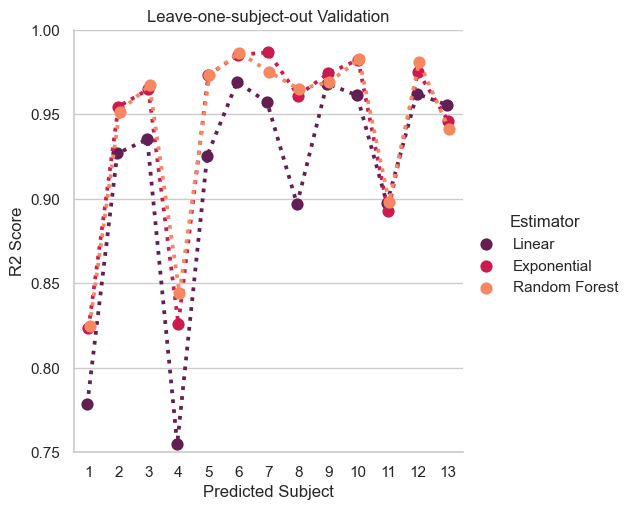

In [7]:
fg = sns.catplot(
    kind="point",
    data=long_cv_result,
    x="subj",
    y="CV_r2",
    hue="Estimator",
    dodge=True,
    linestyles="dotted",
    palette="rocket",
)

fg.set(title="Leave-one-subject-out Validation")
fg.set(ylim=(0.75, 1), ylabel="R2 Score", xlabel="Predicted Subject")
fg.savefig("./leave_one_subject_out.pdf")

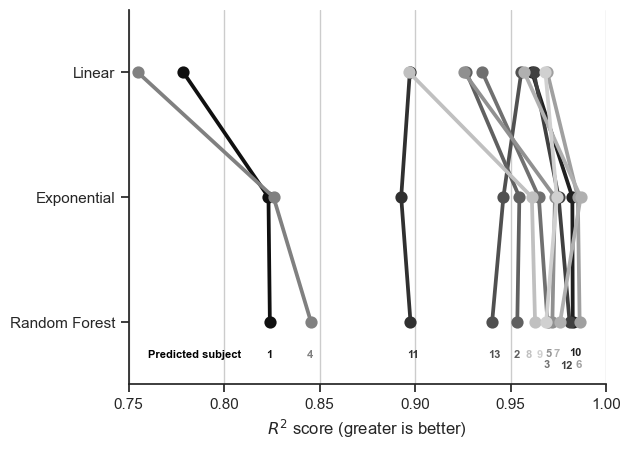

In [126]:
#pip install adjustText
from adjustText import adjust_text



this_result = long_cv_result[long_cv_result["Estimator"] == "Random Forest"]
this_result = this_result.reset_index(drop=True)  #.sort_values("CV_r2", ascending=True).reset_index(drop=True)
palette = sns.color_palette("gray", len(this_result) + 2)[:-2]  # from black to some mid-gray


sns.set_style("ticks",{'axes.grid' : True})

fg = sns.catplot(
    kind="point",
    data=long_cv_result,
    y="Estimator",
    x="CV_r2",
    hue="subj",
    dodge=False,
    hue_order=this_result.subj.values,
    palette=palette,
    legend=False,
    #aspect=1.62,  # golden ratio
)
cm = 1/2.54
fg.fig.set_figwidth(18*cm)
fg.fig.set_figheight(18/1.62*cm)

texts = []
txt_y = 2.3
for ix, row in this_result.iterrows():
    txt = (
        row["subj"]
        if row["CV_r2"] > this_result["CV_r2"].min()
        else f'{row["subj"]}'
    )
    txt = plt.text(
        row["CV_r2"]-0.002,
        txt_y,
        txt,
        ha="center",
        va="center",
        size="medium",
        color=palette[ix],
        weight="semibold",
    )
    texts.append(txt)
plt.text(0.76, txt_y, "Predicted subject", ha="left", va="bottom", size="medium", color="black", weight="semibold")
adjust_text(texts, avoid_self=False, only_move={'text': 'y+', 'points': 'y', 'objects':'y'})
ax = plt.gca()
#ax.set_yticklabels(['Linear','Exponential','Random\nForest'])
#fg.set(title="Leave-one-subject-out Validation")
fg.set(xlim=(0.75, 1), xlabel="$R^2$ score (greater is better)", ylabel="")
fg.savefig("./leave_one_subject_out_by_estimator.pdf")
fg.savefig('leave_one_subject_out_by_estimator.svg', bbox_inches='tight',pad_inches=0)

 I didn't wat to fight with seaborn anymore about fig size, font size, ...
 Here is the figure recreated only with matplotlib (well, still using seaborn color palette):

C:\Users\Newton\AppData\Local\Temp\ipykernel_11876\2315787054.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlim=(0.75, 1),


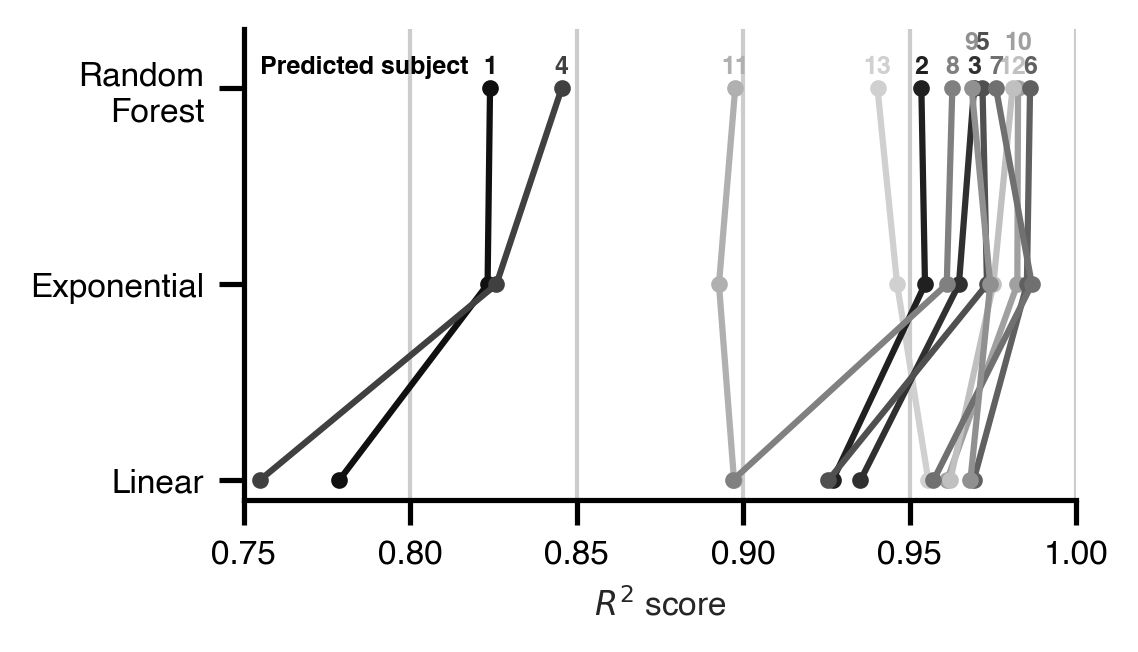

In [173]:
from adjustText import adjust_text

cm = 1/2.54
font = {'family' : 'Helvetica',
        #'sans-serif': ['Helvetica'],
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(8.8*cm, 8.8/1.62*cm)
plt.tight_layout()

this_result = long_cv_result[long_cv_result["Estimator"] == "Random Forest"]
this_result = this_result.reset_index(drop=True)  #.sort_values("CV_r2", ascending=True).reset_index(drop=True)
subj = long_cv_result['subj'].unique()
palette = sns.color_palette("gray", len(subj) + 2)[:-2]  # from black to some mid-gray

texts = []
txt_y = 2.05


for s in subj:
    ind = long_cv_result['subj'] == s
    plt.plot(long_cv_result[ind]['CV_r2'],long_cv_result[ind]['Estimator'],marker='.',color=palette[s-1])
    ind = this_result['subj'] == s
    txt = plt.text(
        this_result[ind]['CV_r2'].iloc[0],
        txt_y,
        s
        if this_result[ind]['CV_r2'].iloc[0] > this_result['CV_r2'].min()
        else f'{s}',
        ha="center",
        va="bottom",
        size=6,
        color=palette[s-1],
        weight="semibold",
    )
    texts.append(txt)

ax.grid(axis='y')
plt.text(0.755, txt_y, "Predicted subject", ha="left", va="bottom", color="black", weight="semibold",fontsize=6)
ax.set(xlim=(0.75, 1),
       ylim=(-0.1,2.3),ylabel="",
       yticklabels=['Linear','Exponential','Random\nForest'])
ax.yaxis.set_tick_params(labelsize=8)
ax.xaxis.set_tick_params(labelsize=8)
ax.set_xlabel("$R^2$ score", fontsize = 8)


#adjust_text(texts, avoid_self=False, only_move={'text': 'y+', 'points': 'y', 'objects':'y'})
texts[12].set_y(txt_y + 0.12) # 9
texts[8].set_y(txt_y + 0.12) # 5
#texts[3].set_y(txt_y + 0.12) # 12
#texts[9].set_y(txt_y + 0.12) # 6
texts[1].set_y(txt_y + 0.12) # 10

fig.savefig('leave_one_subject_out_by_estimator.svg')#, bbox_inches='tight',pad_inches=0)

In [142]:
subj

array([ 1, 10, 11, 12, 13,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [128]:
texts

[Text(0.8219836764635747, 2.3, '1'),
 Text(0.9805769551382462, 2.2902368315386026, '10'),
 Text(0.8956180401671716, 2.3, '11'),
 Text(0.9789229167229254, 2.309763168461399, '12'),
 Text(0.938362611499181, 2.3, '13'),
 Text(0.9515369496057762, 2.3, '2'),
 Text(0.9673726617152447, 2.307510129585691, '3'),
 Text(0.8435119815895027, 2.3, '4'),
 Text(0.9698986528872036, 2.2924898704143093, '5'),
 Text(0.9841860914829509, 2.305757766015697, '6'),
 Text(0.9739554557496926, 2.2942422339843045, '7'),
 Text(0.9608366442091897, 2.3, '8'),
 Text(0.9666417701819351, 2.3, '9')]

In [98]:
this_result[ind]['CV_r2'].iloc[0]

0.982576955138246